# CNN Autoencoder

In this notebook we will see an **image denoising** technique produced by a **CNN autoencoder**.

, using an _autoencoder_, inspired into Francois Chollet [tutorial](https://blog.keras.io/building-autoencoders-in-keras.html).

## 0) Summary

* Image denoising using CNN autoencoders
* Libraries
* Data
* Building the Autoencoder
* Training the model
* Testing the model

## 1) Image denoising using autoencoders

**Autoencoders** are based on **Convolutional Neural Networks** (**CNNs** or **convnets**). 

`Autoencoding` is a data compression algorithm where we have the **compression** and the **decompression** functions that are: 

_data-specific_, _lossy_, and _learned automatically from examples_.

That is the reason why that, differently from the _traditional methods_ we have seen before, this new category of _image denoising methods_
are purely **data-driven**, what means there is no need to phocus on a specific kind of noise.

A **convnet** is a __deep Learning algorithm__ which takes an _input image_, assign _importance_ (learnable weight, 
biases and retains spatial relationships in the data into each one of theirs layers) to various aspects/parts in the 
image and is able to differentiate/reconstruct the same.

It is important to notice that the **convolutional operations** are networks specifically designed to handle _matrix data_, 
more specifically **regular data** (due to their _structured_ representation as two-dimensional grids of pixels with _fixed positions_ and _homogeneous channels_). 
Images are a prime example of such data, represented as matrices of pixels, with dimensions for height, width, and color channel 
(typically, RGB images have three color channels corresponding to red, blue, and green). 
This feature has made CNNs immensely popular in computer vision applications [1, 2, 3, 4].

The general idea behind this kind of code can be visualized here:

![General autoencoder](https://www.pyimagesearch.com/wp-content/uploads/2020/02/keras_denoising_autoencoder_overview.png)
###### Figure: Example of a general autoencoder

Then, the **autoencoder** compreehends an _encoder_ and a _decoder_. 

The **encoder** does the _encoding process_, i.e., transforms the image into a _compressed representation_ at the same time that starts the noisy reduction. 

Then, the _compressed representation_ goes to **decoder** that performs the _decoder process_, restoring the image to its true and recognizable shape. 

The encoder and decoder are usually chosen as _parametric function_, here represented by **convolutional networks**, and the _parameters_ of the encoding/decoding functions are optimized to minimize the **loss function**, which is a measure of the difference between the _denoised image_ and the _true_ one.

At the end of the process, we remove almost all noise in the image.

## 2) Libraries

Once again, the libraries are subject to your installation (see notebook of image denoising).

Here, we will implement the **CNNautoencoder** using `keras`:

In [1]:
try:
    import keras
    from keras import layers
    from keras.datasets import mnist
    import numpy as np
    import matplotlib.pyplot as plt
except:
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.datasets import mnist
    import numpy as np
    import matplotlib.pyplot as plt

## 3) Data

As detailed in the first notebook, we are using as our data the [MNIST](https://keras.io/api/datasets/mnist/) dataset.

### Importing data

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
dimension = x_train.shape[1]

### Pre-processing data

In [5]:
num_data = 1000
frac_train = 0.7
frac_test = 0.3
x_train = x_train[0:int(frac_train*num_data)]
x_test = x_test[0:int(frac_test*num_data)]

We are going to normalize the images between 0 and 1 and to reshape them.

In [6]:
norm_factor = 255.
x_train = x_train.astype('float32')/norm_factor
x_test = x_test.astype('float32')/norm_factor
x_train = np.reshape(x_train, (len(x_train), dimension, dimension, 1))
x_test = np.reshape(x_test, (len(x_test), dimension, dimension, 1))

Here, we need to noisy the images, then, we apply a Gaussian noisy matrix and clip the images between 0 and 1.

In [7]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Visualizing some noise images images.

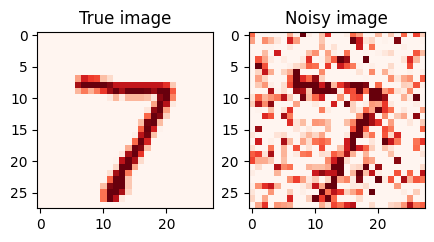

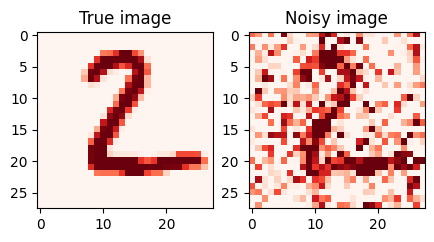

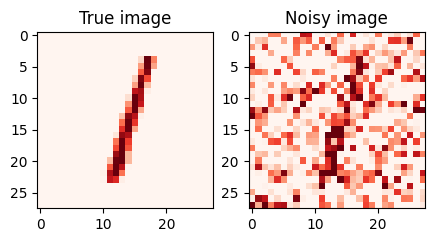

In [8]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(5, 5)
    axes[0].set_title('True image')
    im0 = axes[0].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Noisy image')
    im1 = axes[1].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')

## 4) Building the Autoencoder

Defining the input images for the **autoencoder**:

In [9]:
input_img = keras.Input(shape = (dimension, dimension, 1))

### Encoder

The **encoder** will consist in a stack of `Conv2D` and `MaxPooling2D` layers:
* **Conv2D:**
    * _Number of filters:_ These are the units responsible for _learning_ various characteristics from the images (_edges_, _textures_, or _shapes_). The number of filters determines the depth of the output volume produced by the convolutional layer. Each **filter** learns to _detect_ different features or patterns in the input data.
    * _Kernel size:_ This refers to the dimensions of the _small windows_ or _patches_ responsible for extracting patterns from localized regions of the input image. In other words, the kernel size specifies the _spatial dimensions of the filters_.
* **MaxPooling2D:** Pooling layers play a crucial role in _downsampling_ the size of input feature maps while _preserving_ important _spatial information_. These layers operate by selecting the **maximum** value within each kernel-sized window. Additionally, pooling layers can aid in preventing overfitting by reducing the number of parameters and summarizing the most salient features of the input data.

In [10]:
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(input_img)
x = layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
encoded = layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)

### Decoder

The **decoder** will consist in a stack of `Conv2D` and `UpSampling2D` layers:
* **UpSampling:** Are used to increase the size of input matrices by _repeating_ the values in the rows and columns. Allow for the manipulation of spatial dimensions in the feature maps.

In [11]:
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(encoded)
x = layers.UpSampling2D(size = (2, 2))(x)
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = layers.UpSampling2D(size = (2, 2))(x)
decoded = layers.Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x)

### Autoencoder

Represents the junction of the **encoder** followed by the **decoder**:

In [12]:
autoencoder = keras.Model(input_img, decoded)

We can visualize the **autoencoder**:

In [13]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248  

## 5) Training the model

Before starting training, we have to configure our model to use a **per-pixel** `binary crossentropy` _loss_, and the `Adam` _optimizer_:

In [14]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

### Fitting

Time to learn how to denoise the image by fiting/training the method.

Notice that we are defining a portion of the training set to validate the model at each epoch:

In [15]:
validation_split = 0.1
history = autoencoder.fit(x_train_noisy, x_train, epochs = 60, batch_size = 20, shuffle = True, validation_split = validation_split)

Epoch 1/60
32/32 [==============================] - 1s 10ms/step - loss: 0.4867 - val_loss: 0.3489
Epoch 2/60
32/32 [==============================] - 0s 8ms/step - loss: 0.2507 - val_loss: 0.2046
Epoch 3/60
32/32 [==============================] - 0s 8ms/step - loss: 0.1841 - val_loss: 0.1616
Epoch 4/60
32/32 [==============================] - 0s 8ms/step - loss: 0.1583 - val_loss: 0.1462
Epoch 5/60
32/32 [==============================] - 0s 8ms/step - loss: 0.1467 - val_loss: 0.1366
Epoch 6/60
32/32 [==============================] - 0s 8ms/step - loss: 0.1386 - val_loss: 0.1306
Epoch 7/60
32/32 [==============================] - 0s 8ms/step - loss: 0.1347 - val_loss: 0.1297
Epoch 8/60
32/32 [==============================] - 0s 9ms/step - loss: 0.1306 - val_loss: 0.1235
Epoch 9/60
32/32 [==============================] - 0s 8ms/step - loss: 0.1274 - val_loss: 0.1218
Epoch 10/60
32/32 [==============================] - 0s 8ms/step - loss: 0.1245 - val_loss: 0.1214
Epoch 11/60
32/32 

### Tracking the history of the training stage

Now, we can analise the model taking a look at the losses for the **training** and **validations** sets:

In [16]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [17]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

Visualizing the history of the training:

Text(0.5, 0, 'Epochs')

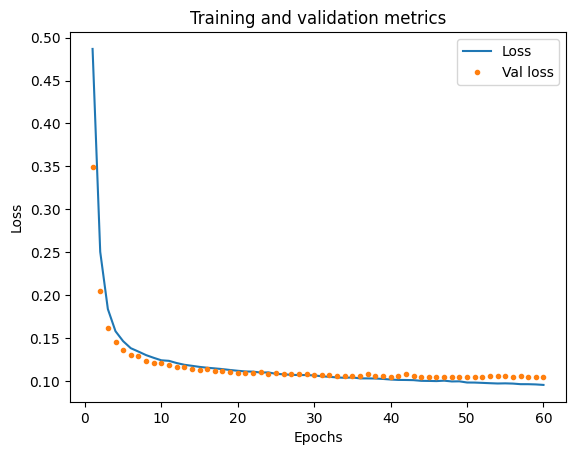

In [18]:
plt.figure(dpi = 100)
plt.plot(epochs, train_loss, label = 'Loss')
plt.plot(epochs, train_val_loss, '.', label = 'Val loss')
plt.title('Training and validation metrics')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

## 6) Testing the model

We can now take a look at the performance of our model by _testing_ it on the _test set_:

In [19]:
all_denoised_images = autoencoder.predict(x_test_noisy)

10/10 [==============================] - 0s 4ms/step


### Visual results

Here, we can compare our visual results looking side by side the noisy, targets and denoised  images.

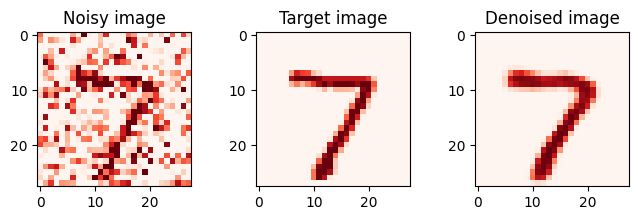

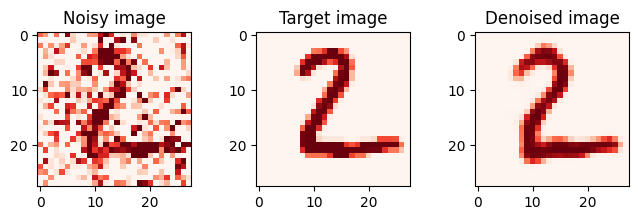

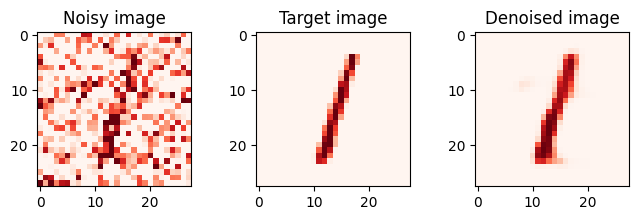

In [20]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(8, 2)
    axes[0].set_title('Noisy image')
    im0 = axes[0].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Target image')
    im1 = axes[1].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[2].set_title('Denoised image')
    im2 = axes[2].imshow(all_denoised_images[i].reshape(dimension, dimension), cmap = 'Reds')

It is super exciting to see that we have finally removed all the noise, in contrast to all the previous traditional methods!

## References

[1] FAN, L. et al. Brief review of image denoising techniques. Visual Computing for Industry, Biomedicine, and Art, v. 2, 2019.

[2] Tian, C. et al. Deep Learning on Image Denoising: An overview. arXiv e-prints, p. arXiv:1912.13171, dez. 2019.

[3] Chollet, F. [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)

[4] de SANTI, N. S. M. Machine learning methods for extracting cosmological information. 2024. doi: [10.11606/T.43.2024.tde-15072024-101341](https://www.teses.usp.br/teses/disponiveis/43/43134/tde-15072024-101341/en.php).